In [1]:
%matplotlib inline

In [2]:
from galsize_models.measurements import load_umachine_sdss_with_meert15
full_sdss, behroozi_complete = load_umachine_sdss_with_meert15()
no_data_mask = np.isnan(full_sdss['Magr_tot_meert15'])

mask = ~no_data_mask & behroozi_complete
sdss = full_sdss[mask]

mask_sf = sdss['ssfr'] >= -10.75
mask_gv = (sdss['ssfr'] < -10.75) & (sdss['ssfr'] >= -11.25)
mask_q = (sdss['ssfr'] < -11.25)

from galsize_models.measurements.sdss_covariance import sdss_measurements_and_cov
sdss_data_vector, sdss_cov = sdss_measurements_and_cov()

In [3]:
from galsize_models.models.load_baseline_catalogs import load_umachine_mock
mock = load_umachine_mock()

Total runtime = 29.55 seconds


# Inspect specific model

In [28]:
from galsize_models.models.bulge_disk_double_power_law import data_vector_prediction
from galsize_models.measurements.sdss_covariance import logsm_bins, logsm_mids
from astropy.table import Table 

chain_fname = "bulge_disk_power_law_chain.dat"

itest = -500
try:
    chain = Table.read(chain_fname, format='ascii')
    chain.sort('lnprob')
    row = chain[itest]
    params = [row[key] for key in row.colnames if key != 'lnprob']
    lnprob = row['lnprob']
    print(row)
except:
    norm1, norm2, alpha1, alpha2, scatter = 0.01, 0.0575, 1, 0.75, 0.185
    params = norm1, norm2, alpha1, alpha2, scatter
    
model_data_vector = data_vector_prediction(params, mock, logsm_bins)



norm1  norm2  alpha1 alpha2 scatter lnprob
------ ------ ------ ------ ------- ------
0.1706 0.2116 0.6954 0.3007  0.0851 -13.83


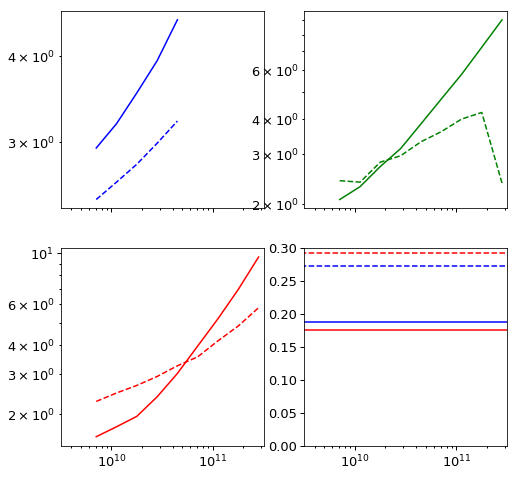

In [29]:
from galsize_models.measurements.sdss_covariance import _get_ifirst_ilast_indices

fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=True)
(ax1, ax2), (ax3, ax4) = axes
axis_list = (ax1, ax2, ax3, ax4)

__=ax1.loglog(); __=ax2.loglog(); __=ax3.loglog(); __=ax4.set_xscale('log')


ifirst, ilast = _get_ifirst_ilast_indices(0)
nskip = ilast-ifirst
__=ax1.plot(10**logsm_mids[:nskip], sdss_data_vector[ifirst:ilast], color='blue')
__=ax1.plot(10**logsm_mids[:nskip], model_data_vector[ifirst:ilast], '--', color='blue')

ifirst, ilast = _get_ifirst_ilast_indices(1)
nskip = ilast-ifirst
__=ax2.plot(10**logsm_mids[:nskip], sdss_data_vector[ifirst:ilast], color='green')
__=ax2.plot(10**logsm_mids[:nskip], model_data_vector[ifirst:ilast], '--', color='green')

ifirst, ilast = _get_ifirst_ilast_indices(2)
nskip = ilast-ifirst
__=ax3.plot(10**logsm_mids[:nskip], sdss_data_vector[ifirst:ilast], color='red')
__=ax3.plot(10**logsm_mids[:nskip], model_data_vector[ifirst:ilast], '--', color='red')

ifirst, ilast = _get_ifirst_ilast_indices(3)
_x = np.logspace(9, 12, len(logsm_mids))
y_data = np.zeros_like(logsm_mids) + sdss_data_vector[ifirst]
y_model = np.zeros_like(logsm_mids) + model_data_vector[ifirst]
__=ax4.plot(_x, y_data, color='blue')
__=ax4.plot(_x, y_model, '--', color='blue')
ifirst, ilast = _get_ifirst_ilast_indices(5)
y_data = np.zeros_like(logsm_mids) + sdss_data_vector[ifirst]
y_model = np.zeros_like(logsm_mids) + model_data_vector[ifirst]
__=ax4.plot(_x, y_data, color='red')
__=ax4.plot(_x, y_model, '--', color='red')


for ax in axis_list:
    xlim = ax.set_xlim(10**9.5, 10**11.5)

ylim4 = ax.set_ylim(0, 0.3)
